In [35]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
from eden.util import configure_logging
import logging

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
from itertools import tee, chain, islice
import numpy as np
import random
from time import time
from graphlearn.graphlearn import GraphLearnSampler
from eden.util import fit,predict
from eden.graph import Vectorizer
# get data
from eden.converter.graph.gspan import gspan_to_eden
from itertools import islice
def get_graphs(dataset_fname, size=100):
    return  islice(gspan_to_eden(dataset_fname),size)

In [37]:
def fit_sample(graphs):
    graphs, graphs_ = tee(graphs)
    sampler=GraphLearnSampler(radius_list=[0,1],thickness_list=[1],
                              min_cip_count=2, min_interface_count=2,
                              vectorizer=Vectorizer(5))
    
    sampler.fit(graphs, nu=0.5, n_jobs=-1)

    print('graph grammar stats:')
    interface_counts, core_counts, cip_counts = sampler.grammar().size()
    print('#interfaces: %d   #cores: %d   #core-interface-pairs: %d' % (interface_counts, core_counts, cip_counts))
    graphs = sampler.sample(graphs_,
                            n_steps=5, n_samples=4,
                            target_orig_cip=True,
                            probabilistic_core_choice=False,
                            score_core_choice= True,
                            max_core_size_diff=0,
                            generator_mode=True,
                            improving_threshold=0.5, accept_static_penalty=0,
                            n_jobs=-1,burnin=1,select_cip_max_tries=200,keep_duplicates=True)
    return graphs

In [38]:
def fit_and_evaluate(original, sampled, local_estimator):
    outputs = []
    for desc,train in [('original',original),
                           ('sample',sampled)]:
        train,train_ = tee(train)
        size=sum(1 for x in train_)
        print "-"*80
        print 'working on %s'%(desc)
        print 'training set sizes: #: %d'%(size)
        if size == 0:
            print 'WARNING: empty dataset'
            outputs.append(0)
        else:
            start=time()
            predictions = predict(train, 
                              estimator=local_estimator, 
                              vectorizer=Vectorizer(4), 
                              mode='predict_proba',
                              n_jobs=-1)
            avg_score=np.mean(predictions[:,1])
            print 'avg score: %.5f' % avg_score
            outputs.append(avg_score)
            print 'elapsed: %.1f sec'%(time()-start)
    return outputs

In [39]:
def evaluate(data_fname, size=None, percentages=None, n_repetitions=None, train_test_split=None):
    # initializing 
    graphs = get_graphs(data_fname, size=size)

    # train/test split
    from eden.util import random_bipartition_iter
    train_global,test_global = random_bipartition_iter(graphs,train_test_split)

    original_repetitions = []
    sample_repetitions = []

    for percentage in percentages:
        originals = []
        originals_samples = []
        samples = []
        for repetition in range(n_repetitions):
            train_global,train_global_ = tee(train_global)
            test_global,test_global_ = tee(test_global)

            from sklearn.linear_model import SGDClassifier
            estimator = SGDClassifier(average=True, class_weight='auto', shuffle=True, loss='log', n_jobs=-1)
            local_estimator = fit(test_global_, 
                                  iterable_neg=None,
                                  vectorizer=Vectorizer(4),
                                  estimator=estimator, n_jobs=-1, n_iter_search=1)
           
            # use shuffled list to create test and sample set
            train,train_reminder = random_bipartition_iter(train_global_,percentage)
            train,train_ = tee(train)
            sampled = fit_sample(train_)

            #evaluate the predictive performance on held out test set
            start=time()
            print "="*80
            print 'repetition: %d/%d'%(repetition+1, n_repetitions)
            print "training percentage:"+str(percentage)
            perf_orig, perf_samp = fit_and_evaluate(train, sampled, local_estimator)
            print 'Time elapsed: %.1f sec'%((time()-start))
            originals.append(perf_orig)
            samples.append(perf_samp)

        original_repetitions.append(originals)
        sample_repetitions.append(samples)
    
    return original_repetitions, sample_repetitions

In [40]:
%%time
#experiment

dataset_names = !cat NCI60/names
dataset = dataset_names[6]
print 'Working with dataset: %s' % dataset 
dataset_fname = 'NCI60/' + dataset + '_orig_pos.gspan'
#dataset_fname = 'bursi.pos.gspan'

configure_logging(logging.getLogger(),verbosity=1, filename='%s_probability_of_samples.log'%dataset)

percentages=[.2,.4,.6,.8,.95]
original_repetitions,\
sample_repetitions = evaluate(dataset_fname,
                              size=600,
                              percentages=percentages,
                              n_repetitions=7,
                              train_test_split=0.7)

Working with dataset: IGROV1_t
graph grammar stats:
#interfaces: 64   #cores: 67   #core-interface-pairs: 292
repetition: 1/7
training percentage:0.2
--------------------------------------------------------------------------------
working on original
training set sizes: #: 84
avg score: 0.99570
elapsed: 0.8 sec
--------------------------------------------------------------------------------
working on sample
training set sizes: #: 252
avg score: 0.99711
elapsed: 3.4 sec
Time elapsed: 17.9 sec
graph grammar stats:
#interfaces: 64   #cores: 67   #core-interface-pairs: 292
repetition: 2/7
training percentage:0.2
--------------------------------------------------------------------------------
working on original
training set sizes: #: 84
avg score: 0.99580
elapsed: 0.8 sec
--------------------------------------------------------------------------------
working on sample
training set sizes: #: 252
avg score: 0.99727
elapsed: 3.8 sec
Time elapsed: 20.1 sec
graph grammar stats:
#interfaces: 6

/Users/costa/anaconda/lib/python2.7/site-packages/sklearn/calibration.py:398: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Users/costa/anaconda/lib/python2.7/site-packages/sklearn/calibration.py:408: RuntimeWarning: overflow encountered in exp
  E = np.exp(AB[0] * F + AB[1])
/Users/costa/anaconda/lib/python2.7/site-packages/sklearn/calibration.py:410: RuntimeWarning: invalid value encountered in multiply
  TEP_minus_T1P = P * (T * E - T1)


graph grammar stats:
#interfaces: 126   #cores: 113   #core-interface-pairs: 677
repetition: 1/7
training percentage:0.8
--------------------------------------------------------------------------------
working on original
training set sizes: #: 336
avg score: 0.99585
elapsed: 4.1 sec
--------------------------------------------------------------------------------
working on sample
training set sizes: #: 1008
avg score: 0.99710
elapsed: 33.0 sec
Time elapsed: 115.7 sec
graph grammar stats:
#interfaces: 126   #cores: 113   #core-interface-pairs: 677
repetition: 2/7
training percentage:0.8
--------------------------------------------------------------------------------
working on original
training set sizes: #: 336
avg score: 0.99548
elapsed: 5.8 sec
--------------------------------------------------------------------------------
working on sample
training set sizes: #: 1008
avg score: 0.99697
elapsed: 19.2 sec
Time elapsed: 105.7 sec
graph grammar stats:
#interfaces: 126   #cores: 113   

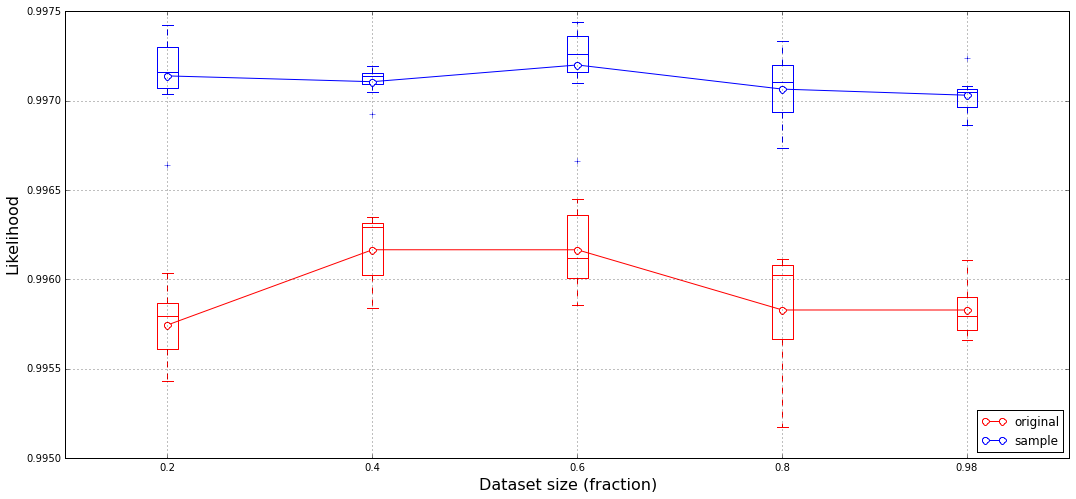

In [47]:
# plot
gc={'color':'g'}
rc={'color':'r'}
bc={'color':'b'}
ws = 0.02
o = np.mean(original_repetitions, axis=1)
s = np.mean(sample_repetitions, axis=1)
plt.figure(figsize=(18,8))
plt.grid()

plt.boxplot(original_repetitions, positions=percentages, widths=ws, capprops=rc, medianprops=rc, boxprops=rc, whiskerprops=rc, flierprops=rc)
plt.plot(percentages,o, color='r', marker='o', markeredgewidth=1, markersize=7, markeredgecolor='r', markerfacecolor='w', label='original')

plt.boxplot(sample_repetitions, positions=percentages, widths=ws, capprops=bc, medianprops=bc, boxprops=bc, whiskerprops=bc, flierprops=bc)
plt.plot(percentages,s, color='b', marker='o', markeredgewidth=1, markersize=7, markeredgecolor='b', markerfacecolor='w', label='sample')

plt.xlim(percentages[0]-.1,percentages[-1]+.1)
plt.ylabel('Likelihood',fontsize=16)
plt.xlabel('Dataset size (fraction)',fontsize=16)
plt.legend(loc='lower right')
plt.savefig('%s_plot_probability_of_samples.pdf' % dataset)

.